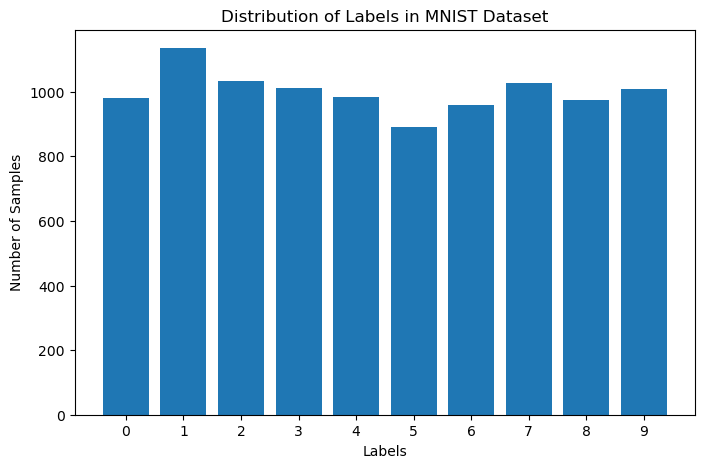

In [41]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Load the MNIST dataset
mnist = datasets.MNIST('./data', train=False, download=True)

# Count the number of samples for each label
label_counts = [0] * 10
for image, label in mnist:
    label_counts[label] += 1

# Labels (0 to 9)
labels = [str(i) for i in range(10)]

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.bar(labels, label_counts, align='center')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Labels in MNIST Dataset')
plt.show()

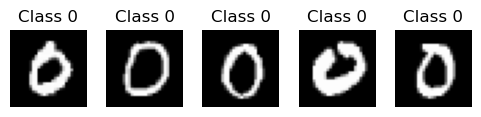

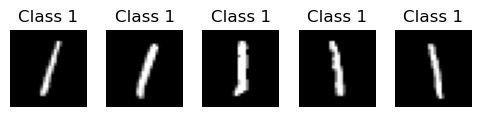

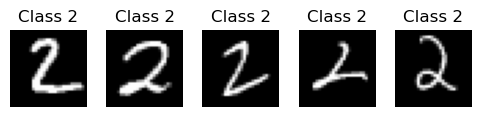

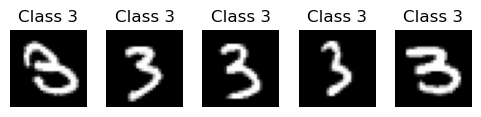

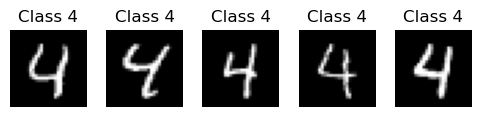

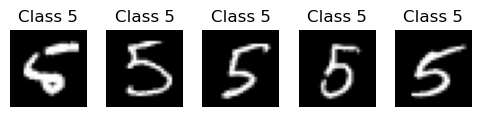

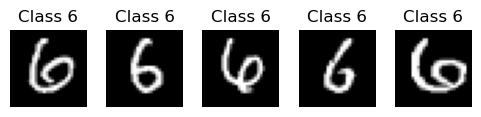

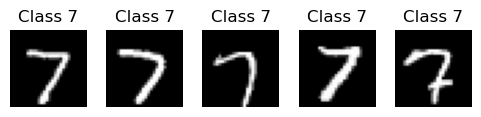

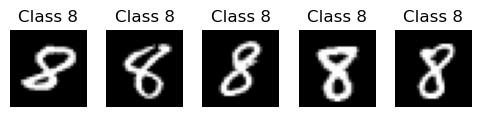

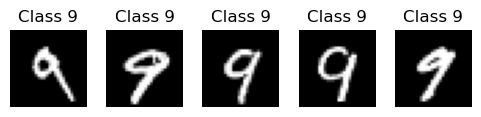

In [42]:
def visualize_samples(dataset, num_samples=5):
    # Create a dictionary to store samples for each class
    samples_by_class = {i: [] for i in range(10)}

    # Iterate through the dataset to collect samples
    for image, label in dataset:
        if len(samples_by_class[label]) < num_samples:
            samples_by_class[label].append(image)

    # Visualize the collected samples
    for label, samples in samples_by_class.items():
        plt.figure(figsize=(6, 1))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(samples[i], cmap='gray')
            plt.title(f'Class {label}')
            plt.axis('off')
        plt.show()

# Visualize 5 samples from each class
visualize_samples(mnist, num_samples=5)


In [43]:
# Class imbalance
label_counts = [0] * 10
for image, label in mnist:
    label_counts[label] += 1

total_samples = sum(label_counts)

imbalance_ratios = [count / total_samples for count in label_counts]

print("\nClass Imbalance Ratios:")
for i, ratio in enumerate(imbalance_ratios              ):
    print(f"Label {i}: {label_counts[i]} \t: Imbalance Ratio = {ratio:.4f}")


Class Imbalance Ratios:
Label 0: 980 	: Imbalance Ratio = 0.0980
Label 1: 1135 	: Imbalance Ratio = 0.1135
Label 2: 1032 	: Imbalance Ratio = 0.1032
Label 3: 1010 	: Imbalance Ratio = 0.1010
Label 4: 982 	: Imbalance Ratio = 0.0982
Label 5: 892 	: Imbalance Ratio = 0.0892
Label 6: 958 	: Imbalance Ratio = 0.0958
Label 7: 1028 	: Imbalance Ratio = 0.1028
Label 8: 974 	: Imbalance Ratio = 0.0974
Label 9: 1009 	: Imbalance Ratio = 0.1009


In [44]:
import torchvision
import torchvision.transforms as transforms

# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the full training dataset
full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Calculate the size of the validation set (e.g., 20% of the training set)
validation_size = int(0.2 * len(full_train_dataset))
training_size = len(full_train_dataset) - validation_size

# Split the full training dataset into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [training_size, validation_size])

# Load the test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders for training, validation, and test
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [45]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_feature_maps(model, input_image, layer_index):
    # Set the model to evaluation mode
    model.eval()

    # Create a forward hook to capture the feature maps
    feature_maps = None
    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    # Register the hook to the selected layer
    target_layer = model.features[layer_index]
    hook = target_layer.register_forward_hook(hook_fn)

    # Forward pass with the input image
    with torch.no_grad():
        model(input_image)

    # Remove the hook
    hook.remove()

    # Get the feature maps as a numpy array
    feature_maps = feature_maps[0].cpu().numpy()

    # Display the feature maps
    num_features = feature_maps.shape[0]
    rows = num_features // 8 + 1

    plt.figure(figsize=(12, 8))
    for i in range(num_features):
        plt.subplot(rows, 8, i + 1)
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.axis('off')
        plt.title(f'Feature Map {i}')

    plt.show()

In [46]:
from torch import nn

class CNN(nn.Module):
    def __init__(self,dim,c_in, num_classes=10,kernel_size=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(c_in, 32,kernel_size= kernel_size)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64,kernel_size= 3)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.dropout = nn.Dropout(0.25)
        la_dim  = (((dim-2)//2)-2)//2
        self.fc1 = nn.Linear(64*la_dim*la_dim, num_classes)
        self.s_max = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.dropout(x)
        x =  x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    def feature_map(self,image):
        conv_m = []
        act_map = []
        pool_map = []

        conv_m.append(self.conv1(image))
        act_map.append(self.relu1(conv_m[-1]))
        pool_map.append(self.maxpool1(act_map[-1]))
        conv_m.append(self.conv2(pool_map[-1]))
        act_map.append(self.relu2(conv_m[-1]))
        pool_map.append(self.maxpool2(act_map[-1]))

        x = self.dropout(pool_map[-1].unsqueeze(0))
        x =  x.reshape(x.size(0), -1)
        x = self.fc1(x)
        prob_class = self.s_max(x)[0]
        return conv_m, act_map, pool_map, prob_class

In [47]:
from torch import optim
from torch import nn

model = CNN(28,1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_iter = 10
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(num_iter):
    model.train()
    r_loss = 0
    crr = 0
    tot = 0
    index =0
    loss = 0

    for  image, label in train_loader:
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        index +=1
        r_loss += loss.item()


    print(f'Epoch {epoch + 1}/{num_iter}, Train Loss: {loss:.4f}')

    #val
    model.eval()
    r_loss = 0
    crr = 0
    tot = 0
    index =0
    loss = 0

    with torch.no_grad():
        for  image, label in val_loader:
            output = model(image)
            loss = criterion(output, label)
            index +=1
    print(f'Epoch {epoch + 1}/{num_iter}, Val Loss: {loss:.4f}')

Epoch 1/10, Train Loss: 0.0320
Epoch 1/10, Val Loss: 0.0157


KeyboardInterrupt: 